In [1]:
import numpy as np
import pandas as pd
import pickle
import os

from create_sequences import create_sequences
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, LayerNormalization, LeakyReLU, Input

import numpy as np
import plotly.graph_objs as go

import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

2024-10-14 19:03:26.816498: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-14 19:03:26.832161: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 19:03:26.851278: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 19:03:26.857055: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 19:03:26.872260: I tensorflow/core/platform/cpu_feature_guar

In [2]:
df_all = pd.read_csv('eua_price_data.csv', thousands=',') 

df_all['Date'] = pd.to_datetime(df_all['Date'], format='%Y-%m-%d')  
df_all = df_all.sort_values(by = 'Date', ascending=True).reset_index(drop = True)


In [3]:
original_EUA = df_all['EUA'].values  
predictors_lst = ['EUA', 'Oil', 'Coal', 'NG', 'USEU', 'S&P_clean', 'DAX']
data = df_all[predictors_lst].values  
dates = df_all['Date'].values

In [4]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

In [5]:
sequence_length = 28
test_data_size = sequence_length + 1

test_data_scaled = data_scaled[-(test_data_size + 1):] 
test_dates = dates[-(test_data_size + 1):]
train_data_scaled = data_scaled[:-(test_data_size + 1)]
train_dates = dates[:-(test_data_size + 1)]

In [6]:
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

In [7]:
# model = Sequential()

# model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]),  
#                activation='tanh', recurrent_activation='sigmoid',
#                return_sequences=True,
#                kernel_regularizer=l2(0.001))) 
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(LSTM(128, 
#                activation='tanh', recurrent_activation='sigmoid', 
#                return_sequences=True, 
#                kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization()) 
# model.add(Dropout(0.3))


# model.add(LSTM(256, 
#                activation='tanh', recurrent_activation='sigmoid', 
#                return_sequences=False, 
#                kernel_regularizer=l2(0.001)))
# model.add(BatchNormalization())

# model.add(Dense(len(predictors_lst), activation='linear'))

# model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

1. Layer Normalization: Replacing BatchNormalization with LayerNormalization for RNNs/LSTMs. Layer normalization is often more effective for sequential data as it normalizes across the features rather than the batch, avoiding issues with batch-dependent statistics in recurrent networks.

1. Recurrent Dropout: Added recurrent_dropout to regularize the recurrent connections, which helps in preventing overfitting in LSTMs.

1. Use of Residual Connections: Added skip (residual) connections between LSTM layers. These are particularly useful for deep RNN architectures as they help mitigate vanishing gradient issues and allow the model to learn better representations.

1. Learning Rate Schedule: Implemented a learning rate scheduler to adjust the learning rate dynamically, which can improve convergence and reduce the risk of overshooting.

1. Optimization: Used the AdamW optimizer instead of Adam. AdamW decouples weight decay from the learning rate, often leading to better generalization.

1. Leaky ReLU for Dense Layer: Changed the activation of the final dense layer to LeakyReLU for a more flexible activation in the prediction layer.

In [8]:
# Learning rate scheduler function
def lr_scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)

model = Sequential()

# First LSTM layer with LayerNormalization and recurrent dropout
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]),
               activation='tanh', recurrent_activation='sigmoid',
               return_sequences=True, recurrent_dropout=0.2,
               kernel_regularizer=l2(0.001)))
model.add(LayerNormalization())
# model.add(Dropout(0.1))

# Second LSTM layer with residual connection, LayerNormalization, and recurrent dropout
model.add(LSTM(128, activation='tanh', recurrent_activation='sigmoid',
               return_sequences=True, recurrent_dropout=0.2,
               kernel_regularizer=l2(0.001)))
model.add(LayerNormalization())
# model.add(Dropout(0.1))

# Third LSTM layer (final) without returning sequences, adding residual connection
model.add(LSTM(256, activation='tanh', recurrent_activation='sigmoid',
               return_sequences=False, recurrent_dropout=0.2,
               kernel_regularizer=l2(0.001)))
model.add(LayerNormalization())

# Dense layer with LeakyReLU activation for flexibility in output
model.add(Dense(len(predictors_lst)))
model.add(LeakyReLU(alpha=0.1))  # LeakyReLU is more flexible for output regression

# Compile the model using AdamW optimizer and a learning rate scheduler
optimizer = AdamW(learning_rate=0.001, weight_decay=1e-5)  # AdamW improves generalization
model.compile(optimizer=optimizer, loss='mse')


I0000 00:00:1728900214.181228  866509 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728900214.181603  866509 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:d5:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728900214.228037  866509 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728900214.228095  866509 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:d5:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728900214.228122  866509 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:73:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

In [9]:
checkpoint_path = "./saved_model_hj_v2/best_model_4.keras"
try:
    model.load_weights(checkpoint_path) 
    with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'rb') as f:
        history = pickle.load(f)
except:

    # Learning rate scheduler callback
    lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                monitor='val_loss', 
                                save_best_only=True,
                                mode='min',  
                                verbose=1)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

    history = model.fit(X_train, y_train, epochs=150, batch_size=128, validation_split=0.05,
                        verbose=1, callbacks=[checkpoint, lr_scheduler_callback, early_stopping])# ,early_stopping]) 
    
    with open(os.path.join(checkpoint_path.split('/')[1],checkpoint_path.split('/')[-1].split('.')[0]), 'wb') as f:
        pickle.dump(history, f)


/home/honggeunjo/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 2 variables whereas the saved optimizer has 36 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


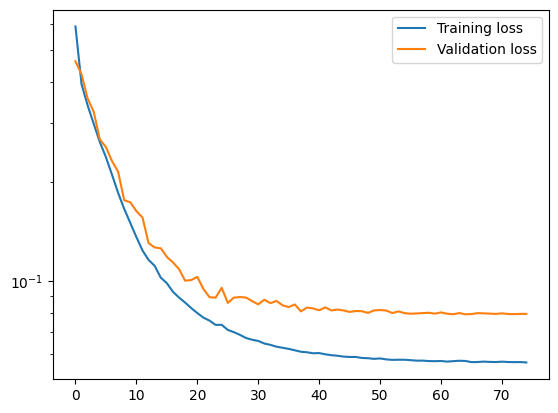

In [13]:
model.load_weights(checkpoint_path) 

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
# plt.ylim([0.01,2.5])
plt.yscale('log')
plt.show()

In [14]:
train_predictions = model.predict(X_train, verbose = 0);
train_predictions_rescaled = scaler.inverse_transform(train_predictions)

test_predictions = model.predict(X_test, verbose = 0);
test_predictions_rescaled = scaler.inverse_transform(test_predictions)

In [288]:
rel_erorrs = []
for i in range(train_predictions_rescaled.shape[1]):
    prediction = train_predictions[:, i]
    ground_truth = y_train[:,i]
    rel_error = np.mean(np.sqrt(((prediction-ground_truth)**2)))
    print(predictors_lst[i])
    print(rel_error)
    rel_erorrs.append(rel_error)

EUA
0.048095083474360985
Oil
0.07791012589582695
Coal
0.0513955281424741
NG
0.057627275933530925
USEU
0.07860176172682923
S&P_clean
0.05784871273221531
DAX
0.07593579592478408


In [18]:
num_of_prediction = 30*24
num_ensemble = 3

ensemble_future_predictions = []
for en in range(num_ensemble):
    future_predictions = []
    current_input = train_predictions[-sequence_length:, :]
    for i in tqdm(range(num_of_prediction)):
        current_input_scaled = np.reshape(current_input, (1, sequence_length, current_input.shape[1]))
        next_prediction = model.predict(current_input_scaled, verbose = 0)
        for j in range(train_predictions_rescaled.shape[1]):
            next_prediction[0, j] *= (1+np.random.normal(0, rel_erorrs[j]))
        future_predictions.append(next_prediction[0])  
        current_input = np.concatenate([current_input[1:], [next_prediction[0]]], axis=0)
    ensemble_future_predictions.append(scaler.inverse_transform(np.array(future_predictions)))

ensemble_future_predictions= np.array(ensemble_future_predictions)


# future_predictions_original = scaler.inverse_transform(future_predictions)
future_dates = [pd.to_datetime(train_dates[-1]) + pd.DateOffset(days=i + 1) for i in range(num_of_prediction)]

In [28]:

# Create traces for each plot
trace1 = go.Scatter(x=dates, y=original_EUA, mode='lines', name='Historical EUA Price', 
                    line=dict(color='blue'))

trace2 = go.Scatter(x=future_dates, y=ensemble_future_predictions[0,:,0], mode='lines', 
                    name='Predicted EUA Price_1', 
                    line=dict(color='red'))

trace3 = go.Scatter(x=future_dates, y=ensemble_future_predictions[1,:,0], mode='lines', 
                    name='Predicted EUA Price_2', 
                    line=dict(color='purple'))

trace4 = go.Scatter(x=future_dates, y=ensemble_future_predictions[2,:,0], mode='lines', 
                    name='Predicted EUA Price_3', 
                    line=dict(color='orange'))

trace5 = go.Scatter(x=train_dates[-train_predictions_rescaled.shape[0]:], 
                    y=train_predictions_rescaled[:, 0], mode='lines+markers', 
                    name='Train Predicted EUA Price', marker=dict(color='green', size=4), 
                    line=dict(color='green'))

# Layout for the plot
layout = go.Layout(
    title='EUA Price Prediction for the Next 24 Months',
    xaxis=dict(title='Date'),
    yaxis=dict(title='EUA Price'),
    legend=dict(x=0, y=1, traceorder='normal'),
    height=600,
    width=1000
)

# Create the figure with the traces
fig = go.Figure(data=[trace1, trace2, trace3, trace4, trace5], layout=layout)

# Show the figure (interactive plot)
fig.show()

In [333]:
ensemble_future_predictions.shape

(3, 720, 7)

In [20]:
ensemble_future_predictions = np.load('temp.npy')

/tmp/ipykernel_866509/3608131112.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "g." (-> marker='.'). The keyword argument will take precedence.
  plt.plot(train_dates[-train_predictions_rescaled.shape[0]:], train_predictions_rescaled[:, 0], 'g.', marker='.', markersize=2, label='Train Predicted EUA Price')


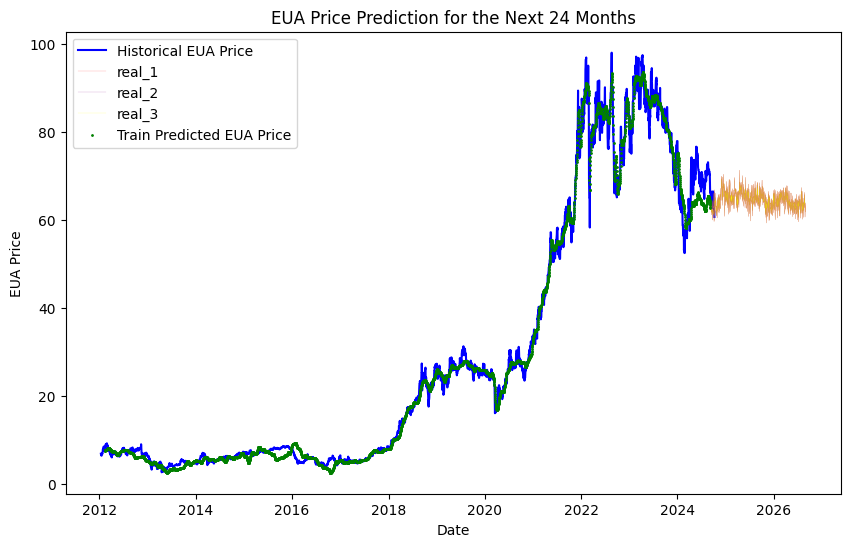

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(dates, original_EUA, 'b', label='Historical EUA Price')  # 원본 EUA 데이터
# plt.plot(train_dates, scaler.inverse_transform(test_data_scaled)[:, 0], 'skyblue', label='Test EUA Price')  # 테스트 데이터
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'red', linewidth = 0.1, label = 'real_1')
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'purple', linewidth = 0.1, label = 'real_2')
plt.plot(future_dates, ensemble_future_predictions[0, :, 0].T, 'yellow', linewidth = 0.1, label = 'real_3')
plt.plot(train_dates[-train_predictions_rescaled.shape[0]:], train_predictions_rescaled[:, 0], 'g.', marker='.', markersize=2, label='Train Predicted EUA Price')


plt.xlabel('Date')
plt.ylabel('EUA Price')
plt.title('EUA Price Prediction for the Next 24 Months')
plt.legend()
plt.show()